# Fourth Experiment

---

In this notebook, run on [Colab](https://colab.research.google.com), we are going to perform our fourth experiment with **Detectron2** with our custom use case.

This notebook will be the last of the fourth experiments we have planned to perform, basicaly to check the impact of various initial learning rates within the training process of the model we have decided to mobilize for this study.

The chosen model is a Faster/Mask R-CNN COCO instance segmentation model, with ResNet/FPN backbone combination, based on ResNet-50 model and with a learning rate scheduler of 3 (more details can be found [here](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md)).

As detailed in the presentation page, we choose this one because it obtains the best speed/accuracy tradeoff.

Let's going on!

---

## Detectron2 installation and basic setup

In this section, we are going to adapt the procedure given in the notebook present in [Detectron2](https://github.com/facebookresearch/detectron2) GitHub homepage.

As always, the prerequisite step consists on loading the appropriate packages to perform our work:

In [1]:
# Needed packages:
import json, cv2, random, torch, torchvision, yaml
import pandas as pd
import numpy as np
from PIL import Image
from utils import rle_to_mask
from google.colab.patches import cv2_imshow

Now, we need to check and get some configuration characteristics:

In [2]:
# Check what GPU is at our disposal in this session:
!nvidia-smi

Thu Aug 20 13:09:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Check some configuration characteristics:
print("*** Some configuration characteristics:")
print("- Torch version: {}".format(torch.__version__))
print("- Cuda: {}".format(torch.cuda.is_available()))

*** Some configuration characteristics:
- Torch version: 1.6.0+cu101
- Cuda: True


In [4]:
# Check GCC version:
!gcc --version

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



We can now begin the core installation process:

In [5]:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions:

# Install dependencies:
!pip install pyyaml==5.1 pycocotools==2.0.1

# Install Detectron2 (Colab has CUDA 10.1 + torch 1.6):
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


All is OK! We can now move on basic setup of the tool:

In [6]:
# Needed Detectron2 packages:
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer

In [7]:
# Set Detectron2 monitoring:
setup_logger(output='../models/experiment_4')

<Logger detectron2 (DEBUG)>

---

## Register the datasets

It's now time to register the datasets we have constituted in a previous notebook. As they are custom ones, we need to operate carefully and to follow the instructions given in the [Detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).

In [8]:
# Custom function to register custom dataset:
def get_severstal_dicts(dataset_path):
    """ Get Severstal dictionaries """
    
    # Open CSV description file:
    dataset_file_path = dataset_path + 'annotations.csv'
    dataset = pd.read_csv(dataset_file_path)
    
    # Initialize list of dictionaries for dataset:
    dataset_dicts = []
    
    # Go through dataset:
    for idx, row in dataset.iterrows():
        # Initialize record:
        record = {}
        # Populate first elements of record:
        file_name = dataset_path + row['ImageId']
        width, height = Image.open(file_name).size
        record['file_name'] = file_name
        record['height'] = height
        record['width'] = width
        record['image_id'] = idx
        # Initialize last element of record:
        annotations = []
        # Get mask:
        rle = row['EncodedPixels']
        mask = rle_to_mask(rle)
        # Determine contours:
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # Populate last element of record:
        for contour in contours:
            contour_array = contour.reshape(-1, 2)
            px = [i[0] for i in contour_array]
            py = [j[1] for j in contour_array]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            x0, y0 = int(np.min(px)), int(np.min(py))
            x1, y1 = int(np.max(px)), int(np.max(py))
            if (len(poly)%2)==0 and len(poly)>=6:
                annotation = {'bbox': [x0, y0, x1, y1],
                              'bbox_mode': BoxMode.XYXY_ABS,
                              'segmentation': [poly],
                              'category_id': row['ClassId'] - 1,
                              'iscrowd': 0}
                annotations.append(annotation)
        record['annotations'] = annotations
        # Add to list of dictionaries:
        dataset_dicts.append(record)
    
    # Return results:
    return dataset_dicts

In [9]:
# Set annotations:
severstal_annotations = ['Type 1',
                         'Type 2',
                         'Type 3',
                         'Type 4']

In [10]:
# Register training and testing datasets:
for ds in ['training_ds', 'testing_ds']:
    DatasetCatalog.register(ds, lambda ds=ds: get_severstal_dicts('../data/' + ds + '/'))
    MetadataCatalog.get(ds).set(thing_classes=severstal_annotations)

In [11]:
# Set metadata:
severstal_metadata = MetadataCatalog.get('training_ds')

In [12]:
# Get training and testing datasets dictionaries lists:
training_ds_dicts = get_severstal_dicts('../data/training_ds/')
testing_ds_dicts = get_severstal_dicts('../data/testing_ds/')

In [13]:
# Display random recording:
print('*** A random recording from testing dataset:\n')
print(testing_ds_dicts[2092])

*** A random recording from testing dataset:

{'file_name': '../data/testing_ds/fea8e46ad.jpg', 'height': 256, 'width': 1600, 'image_id': 2092, 'annotations': [{'bbox': [1339, 24, 1353, 255], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[1347.5, 24.5, 1346.5, 25.5, 1344.5, 25.5, 1343.5, 26.5, 1341.5, 26.5, 1340.5, 27.5, 1339.5, 27.5, 1339.5, 141.5, 1340.5, 142.5, 1340.5, 255.5, 1353.5, 255.5, 1353.5, 195.5, 1352.5, 194.5, 1352.5, 140.5, 1351.5, 139.5, 1351.5, 107.5, 1350.5, 106.5, 1350.5, 74.5, 1349.5, 73.5, 1349.5, 41.5, 1348.5, 40.5, 1348.5, 24.5]], 'category_id': 2, 'iscrowd': 0}, {'bbox': [1321, 21, 1336, 254], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[1321.5, 21.5, 1321.5, 131.5, 1322.5, 132.5, 1322.5, 254.5, 1336.5, 254.5, 1336.5, 226.5, 1335.5, 225.5, 1335.5, 168.5, 1334.5, 167.5, 1334.5, 109.5, 1333.5, 108.5, 1333.5, 51.5, 1332.5, 50.5, 1332.5, 21.5]], 'category_id': 2, 'iscrowd': 0}, {'bbox': [710, 2, 735, 255], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmenta

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the testing set:

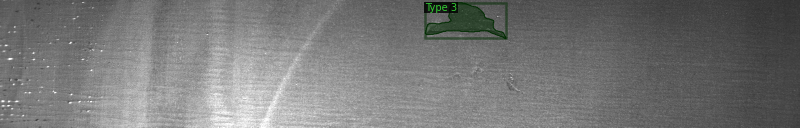

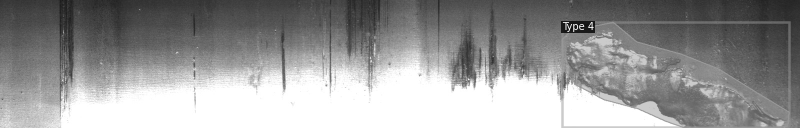

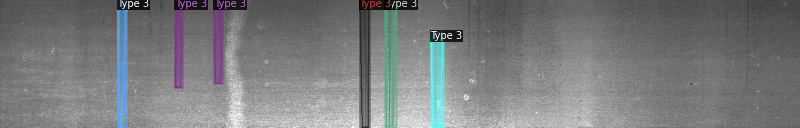

In [14]:
# Some random visualizations:
for recording in random.sample(testing_ds_dicts, 3):
    img = cv2.imread(recording['file_name'])
    visualizer = Visualizer(img[:, :, ::-1],
                            metadata=severstal_metadata,
                            scale=0.5)
    out = visualizer.draw_dataset_dict(recording)
    cv2_imshow(out.get_image()[:, :, ::-1])

---

## Perform training

Now that our custom datasets have been correctly loaded, we are going to run a training.

For that, we are going to begin setting up the configuration of the tool:

In [15]:
# See https://detectron2.readthedocs.io/modules/config.html for more information

# Detectron2 custom (and very basic) configuration:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml')
cfg.DATASETS.TRAIN = ('training_ds',)
cfg.DATASETS.TEST = ('testing_ds',)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.000025
cfg.SOLVER.MAX_ITER = 400
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.TEST.EVAL_PERIOD = 20
cfg.OUTPUT_DIR = '../models/experiment_4/training'

We can now run the training:

In [16]:
# Define trainer:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = '../models/experiment_4/training'
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

# Set trainer:
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)

# Perform training:
trainer.train()

[08/20 13:14:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

[08/20 13:14:29 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:331: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:331: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.6/dist-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_

[08/20 13:14:40 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   Type 1   | 1010         |   Type 2   | 118          |   Type 3   | 3909         |
|   Type 4   | 915          |            |              |            |              |
|   total    | 5952         |            |              |            |              |
[08/20 13:14:40 d2.data.common]: Serializing 2104 elements to byte tensors and concatenating them all ...
[08/20 13:14:42 d2.data.common]: Serialized dataset takes 19.11 MiB
[08/20 13:14:42 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/20 13:14:42 d2.evaluation.coco_evaluation]: 'testing_ds' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO form

In [17]:
# Export model configuration to YAML file:
model_config = cfg.dump()

# Save model configuration:
with open('../models/experiment_4/training/model_final.yaml', 'w') as f:
    yaml.dump(model_config, f)

---

## Evaluate trained model

Now that we have performed the training, we can evaluate our model performance using AP metric implemented in COCO API:

In [18]:
# Model evaluation:
evaluator = COCOEvaluator('testing_ds',
                          cfg,
                          False,
                          output_dir='../models/experiment_4/testing/')
testing_loader = build_detection_test_loader(cfg, 'testing_ds')
print(inference_on_dataset(trainer.model, testing_loader, evaluator))

[08/20 15:27:38 d2.data.common]: Serializing 2104 elements to byte tensors and concatenating them all ...
[08/20 15:27:41 d2.data.common]: Serialized dataset takes 19.11 MiB
[08/20 15:27:41 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/20 15:27:41 d2.evaluation.evaluator]: Start inference on 2104 images
[08/20 15:27:43 d2.evaluation.evaluator]: Inference done 11/2104. 0.0835 s / img. ETA=0:06:09
[08/20 15:27:48 d2.evaluation.evaluator]: Inference done 40/2104. 0.0818 s / img. ETA=0:06:05
[08/20 15:27:53 d2.evaluation.evaluator]: Inference done 69/2104. 0.0813 s / img. ETA=0:05:57
[08/20 15:27:58 d2.evaluation.evaluator]: Inference done 97/2104. 0.0819 s / img. ETA=0:05:54
[08/20 15:28:03 d2.evaluation.evaluator]: Inference done 126/2104. 0.0820 s / img. ETA=0:05:49
[08/20 15:28:08 d2.evaluation.evaluator]: Inference done 155/2104. 0.0818 s / img. ETA=0:05:43
[08/20 15:28:13 d2.evalua

---

## Run inferences with trained model

To conclude this notebook, we can run some inferences with the model we have trained previously:

In [19]:
# Build predicor:
cfg.MODEL.WEIGHTS = '../models/experiment_4/training/model_final.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

In [20]:
# Pick up three random recordings on training dataset:
random_training = random.sample(training_ds_dicts, 3)

*** Original image with its labeled defects:


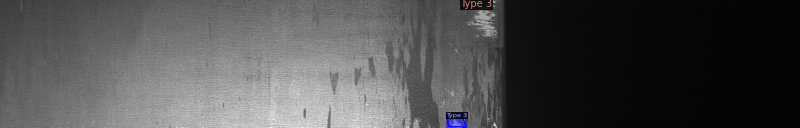

*** Model prediction:


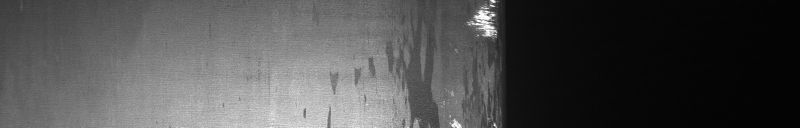

In [21]:
# First random prediction:
img = cv2.imread(random_training[0]['file_name'])

print('*** Original image with its labeled defects:')
visualizer = Visualizer(img[:, :, ::-1],
                        metadata=severstal_metadata,
                        scale=0.5)
out = visualizer.draw_dataset_dict(random_training[0])
cv2_imshow(out.get_image()[:, :, ::-1])

print('*** Model prediction:')
outputs = predictor(img)
visualizer_pred = Visualizer(img[:, :, ::-1],
                             metadata=severstal_metadata,
                             scale=0.5)
pred = visualizer_pred.draw_instance_predictions(outputs['instances'].to('cpu'))
cv2_imshow(pred.get_image()[:, :, ::-1])

*** Original image with its labeled defects:


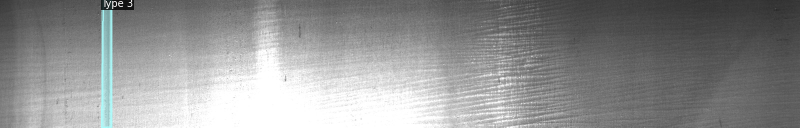

*** Model prediction:


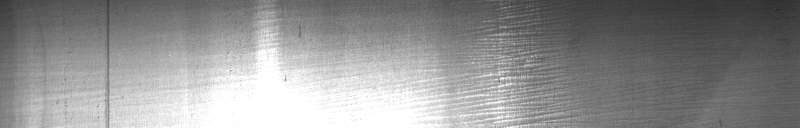

In [22]:
# Second random prediction:
img = cv2.imread(random_training[1]['file_name'])

print('*** Original image with its labeled defects:')
visualizer = Visualizer(img[:, :, ::-1],
                        metadata=severstal_metadata,
                        scale=0.5)
out = visualizer.draw_dataset_dict(random_training[1])
cv2_imshow(out.get_image()[:, :, ::-1])

print('*** Model prediction:')
outputs = predictor(img)
visualizer_pred = Visualizer(img[:, :, ::-1],
                             metadata=severstal_metadata,
                             scale=0.5)
pred = visualizer_pred.draw_instance_predictions(outputs['instances'].to('cpu'))
cv2_imshow(pred.get_image()[:, :, ::-1])

*** Original image with its labeled defects:


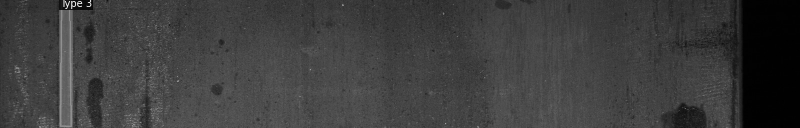

*** Model prediction:


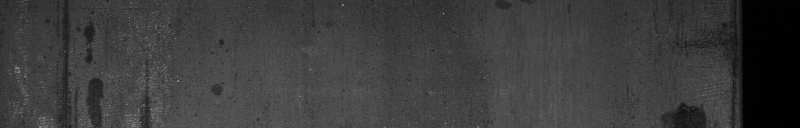

In [23]:
# Third random prediction:
img = cv2.imread(random_training[2]['file_name'])

print('*** Original image with its labeled defects:')
visualizer = Visualizer(img[:, :, ::-1],
                        metadata=severstal_metadata,
                        scale=0.5)
out = visualizer.draw_dataset_dict(random_training[2])
cv2_imshow(out.get_image()[:, :, ::-1])

print('*** Model prediction:')
outputs = predictor(img)
visualizer_pred = Visualizer(img[:, :, ::-1],
                             metadata=severstal_metadata,
                             scale=0.5)
pred = visualizer_pred.draw_instance_predictions(outputs['instances'].to('cpu'))
cv2_imshow(pred.get_image()[:, :, ::-1])

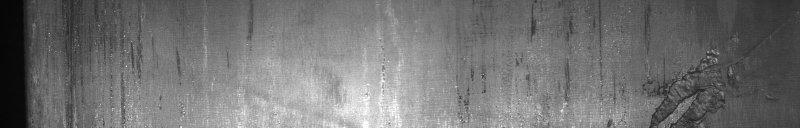

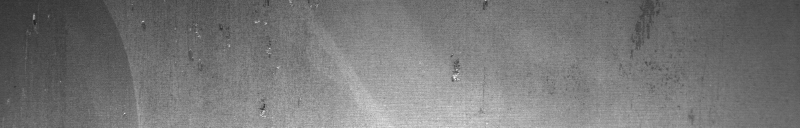

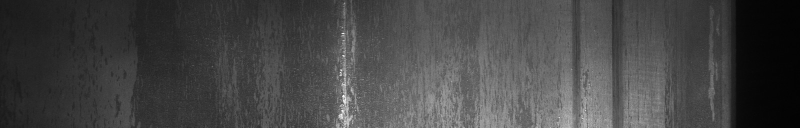

In [24]:
# Random predictions on testing dataset:
for recording in random.sample(testing_ds_dicts, 3):
    img = cv2.imread(recording['file_name'])
    outputs = predictor(img)
    visualizer_pred = Visualizer(img[:, :, ::-1],
                                 metadata=severstal_metadata,
                                 scale=0.5)
    pred = visualizer_pred.draw_instance_predictions(outputs['instances'].to('cpu'))
    cv2_imshow(pred.get_image()[:, :, ::-1])